## Brownlee adapted for live update

https://machinelearningmastery.com/use-features-lstm-networks-time-series-forecasting/

### Yet to do

1. Record the predicted data and create live streaming chart
2. Duplication in the live streaming input 
3. Add Twitter live sentiment analysis
4. Add additional features like volume, bidask, etc

In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Bidirectional
from math import sqrt
import matplotlib.pyplot as plt
import numpy
from numpy import concatenate
import seaborn as sns

# import tensorflowvisu
import math
import numpy as np
import glob
from sklearn import preprocessing
# Set charts to view inline
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime

from math import sqrt

from numpy import concatenate
import sys
import requests
import datetime
import time

Using TensorFlow backend.


In [2]:
# plot size
plt.rcParams["figure.figsize"] = (15,10)

***

## Part 1 -- Data preparation
We load the price, volume, transaction, trades per minute, bidask, epu_idx and semantic (tweet) score from the spreadsheet we combined them into.

In [3]:
global df

In [4]:
# DATA698  Crypto Project
# market_data.py
#This file pulls the historical market data from cryptocompare.com


def arg_check():
    if len(arg) != 3:
        print ("Usage: Crypto BaseCurrency candle_size")
        
#https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=1828
        
def minute_price_historical(symbol, comparison_symbol, limit, aggregate, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histominute?fsym={}&tsym={}&limit={}&aggregate={}'\
            .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    if exchange:
        url += '&e={}'.format(exchange)
    page = requests.get(url)
    data = page.json()['Data']
    df = pd.DataFrame(data)
    df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in df.time]
    return df


def writecsv(df, filename):
    df[['timestamp','close']].to_csv(filename,index=False)
    print(filename, "saved")


def main():
    minute = minute_price_historical('BTC', 'USD', 2000, 1)
    writecsv(minute, './data/BTC_minute.csv')
    
if  __name__ =='__main__':
    main()

./data/BTC_minute.csv saved


In [5]:
df = pd.read_csv("./data/BTC_minute.csv")#,usecols=['timestamp','close'])
df['timestamp'] = pd.to_datetime(df['timestamp'])

df.head()

# Taking the historical price alone
series = Series(df.drop('timestamp',axis=1)['close'])

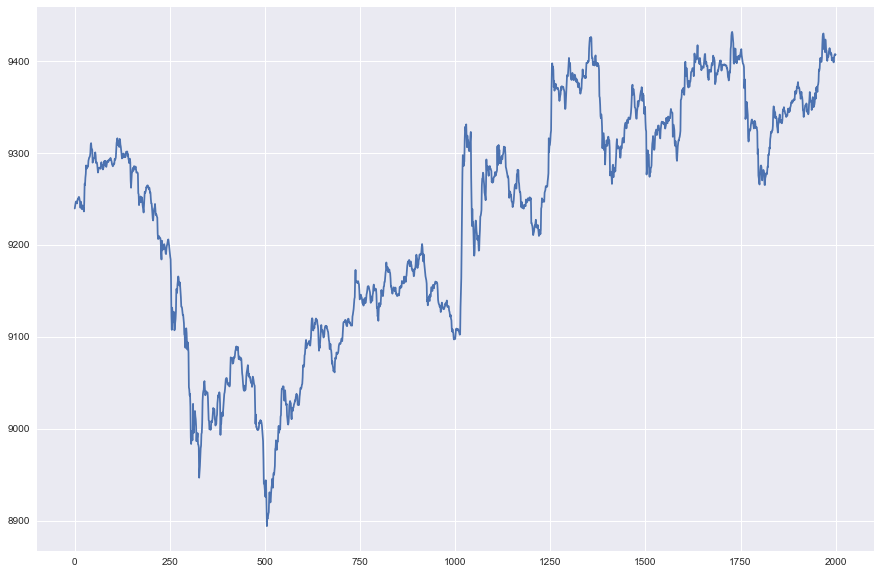

In [6]:
# get the data
#fname='data/btc_new_3_24.csv'
#df = pd.read_csv(fname)
df['close'].plot()
plt.show()

In [7]:
# we must drop any NaN rows for LSTM to run
df.dropna(inplace=True)

### Brownlee functions
These are some of the functions Brownlee wrote to transform and un-transform the data. We'll be using adapted versions for our model. We won't use all of them. Unlike prior runs, we will use his differencing function to make the data stationary before scaling it later in the process.

In [8]:
# date-time parsing function for loading the dataset; NOT USED
def parser(x):
	return datetime.strptime(x, '%Y-%b')

# frame a sequence as a supervised learning problem; NOT USED
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
# this base model is the one that worked best for me
# it uses hidden layers of 100, 20, 10 and 5 neurons

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, batch_input_shape=(batch_size, X.shape[1], X.shape[2])))
    model.add(LSTM(20, return_sequences=True))
    model.add(LSTM(10, return_sequences=True))
    model.add(LSTM(5))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
        model.reset_states()
    return model





# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# this function runs the lstm model for the repeat experiment function below
# I've commented out the data prep part, since we've done that already
# run a repeated experiment
def experiment(n_repeats, batch_size=1, n_epochs=1, n_neurons=1):
	# transform data to be stationary
	# raw_values = series.values
	# diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	# supervised = timeseries_to_supervised(diff_values, features)
	# supervised_values = supervised.values[features:,:]
	# split data into train and test-sets
	# train, test = supervised_values[0:-12, :], supervised_values[-12:, :]
	# transform the scale of the data
	# scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(n_repeats):
		# fit the base model
		lstm_model = fit_lstm(train_scaled, batch_size, n_epochs, n_neurons)
		# forecast test dataset
		predictions = list()
		for i in range(len(test_scaled)):
			# predict
			X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
			yhat = forecast_lstm(lstm_model, 1, X)
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-600:], predictions))
		print('')
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		print('')
		error_scores.append(rmse)
	return error_scores


# this function can be used to configure and run multiple trials of a model
def run():
	n_repeats = 2
	batch_size = 1
	n_epochs = 10
	n_neurons = 100
	# run the experiment
	results = pd.DataFrame()
	results['results'] = experiment(n_repeats, batch_size, n_epochs, n_neurons)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment.csv', index=False)
    # save boxplot
	results.boxplot()
	plt.show()
 
# to run it
# run()


In [9]:
#def fit_lstm(train, batch_size, nb_epoch, neurons):
#    X, y = train[:, 0:-1], train[:, -1]
#    X = X.reshape(X.shape[0], 1, X.shape[1])
#    model = Sequential()
#    model.add(Bidirectional(LSTM(neurons, return_sequences=True), batch_input_shape=(batch_size, X.shape[1], X.shape[2])))
#    model.add(LSTM(20, return_sequences=True))
#    model.add(LSTM(10, return_sequences=True))
#    model.add(LSTM(5))
#    model.add(Dense(1))
#    model.compile(loss='mean_squared_error', optimizer='adam')
#    for i in range(nb_epoch):
#        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
#        model.reset_states()
#    return model


In [10]:
#fit_lstm(train_scaled, 1, 10, 100)

In [11]:
## Not used for live update
#df.head()

### Difference the data
#Several variables are not stationary. For LSTM to work, the have to be differenced. We do that for transactions, bid-ask spread, volume and trades per minute. We will difference price in the next step so it synchronizes with the Brownlee functions.

#df_temp = df[['trans', 'bidask', 'volume', 'tpm']].diff(1,0)

#df_temp.info()

### Put it back together

# concatenate the data, rename columns
#new_df = pd.DataFrame(pd.concat([df_temp, df[['price','epu_idx', 'exp_sem']]], axis=1))

#new_df.head()

### Create the 1-day lagged price as target variable 'y'
We are trying to predict the next day's price based on the data we know today. The next series of steps adds our features together with y = t+1. So now we have the next day's true price (y) and today's knowledge (X) in each observation.

#### Step 1: Difference the price

In [12]:
# first we have to difference the price
# we're using Brownlee's function to do this so we can undifference it later
raw_values = df['close'].values
diff_values = difference(raw_values, 1)
diff_values.head()

0    2.82
1    2.58
2    2.16
3   -0.09
4   -0.11
dtype: float64

In [13]:
len(diff_values)
# check it
df['close'].diff(1).head()

0     NaN
1    2.82
2    2.58
3    2.16
4   -0.09
Name: close, dtype: float64

#### Step 2: Create our lagged ahead target price 'y'

In [14]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)

supervised.head()

,0,0
0,NaN,2.82
1,2.82,2.58
2,2.58,2.16
3,2.16,-0.09
4,-0.09,-0.11


***

## Part 2 -- Modeling

### Modified Brownlee for multiple experiments
This code will run repeat models and average them. It takes repeats, number of epochs and number of neurons in first layer and feeds those parameters to the lstm function above.

In [15]:
# configure a repeated experiment
# batch size should remain at 1; repeats, epochs and neurons can change
def run():
	n_repeats = 2
	batch_size = 1
	n_epochs = 10
	n_neurons = 100
	# run the experiment
	results = pd.DataFrame()
	results['results'] = experiment(n_repeats, batch_size, n_epochs, n_neurons)
	# summarize results
	print(results.describe())
	# save results
	results.to_csv('experiment.csv', index=False)
    # save boxplot
	results.boxplot()
	plt.show()
 
# entry point
#run()

### Single run model
This just runs a single model, and you can then plot the predicted vs. actual test values in the bottom cell.

In [16]:
# scale train and test data to [-1, 1]
def scale_one(supervised_df):
    supervised_df.dropna(inplace=True)
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(supervised_df)
    # transform train
    df_scaled = scaler.transform(supervised_df)
    return scaler, df_scaled

In [17]:
# split data into train test-sets
scalar, train_scaled = scale_one(supervised)


In [18]:
lstm_model = fit_lstm(train_scaled, 1, 10, 100)

Epoch 1/1
 - 15s - loss: 0.0202
Epoch 1/1
 - 13s - loss: 0.0198
Epoch 1/1
 - 13s - loss: 0.0196
Epoch 1/1
 - 13s - loss: 0.0196
Epoch 1/1
 - 13s - loss: 0.0196
Epoch 1/1
 - 13s - loss: 0.0195
Epoch 1/1
 - 13s - loss: 0.0195
Epoch 1/1
 - 13s - loss: 0.0195
Epoch 1/1
 - 13s - loss: 0.0195
Epoch 1/1
 - 13s - loss: 0.0195


In [19]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 1, 100)               40800     
_________________________________________________________________
lstm_2 (LSTM)                (1, 1, 20)                9680      
_________________________________________________________________
lstm_3 (LSTM)                (1, 1, 10)                1240      
_________________________________________________________________
lstm_4 (LSTM)                (1, 5)                    320       
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    6         
Total params: 52,046
Trainable params: 52,046
Non-trainable params: 0
_________________________________________________________________


#### Live Prediction

In [20]:
# scale train and test data to [-1, 1]
def transform_test(test_new_records):

    #print(test_new_records)
    # Concatinate original train and new test data to take a difference
    test_new_records = pd.concat([pd.DataFrame(df.iloc[-2:,:]),test_new_records])
    
    # Perform difference and timeseries on the new dataset
    test_diff_new_records = difference(test_new_records[['close']].values,1)
    #print(test_diff_new_records)
    ts_test_diff_new_records = timeseries_to_supervised(test_diff_new_records, 1)
    ts_test_diff_new_records.dropna(inplace=True)
    # Scale transform test dataset
    test_scaled = scalar.transform(ts_test_diff_new_records)
    
    return scalar, test_scaled

In [21]:
# Update LSTM model
def update_model(model, train, batch_size, updates):
    
            
    # Perform difference and timeseries on the new dataset
    train_diff_new_records = difference(train,1)
    
    # Perform other regular updates
    #print(test_diff_new_records)
    ts_train_diff_new_records = timeseries_to_supervised(train_diff_new_records, 1)
    
    # Scale transform train dataset    
    scalar, train_scaled = scale_one(ts_train_diff_new_records)
    
    X, y = train_scaled[:, 0:-1], train_scaled[:, -1]
    
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    for i in range(updates):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
        model.reset_states()
    
    
    return model

In [30]:
def minute_price_historical(lstm_model, symbol, comparison_symbol, limit, aggregate, exchange=''):
    url = 'https://min-api.cryptocompare.com/data/histominute?fsym={}&tsym={}&limit={}&aggregate={}'\
        .format(symbol.upper(), comparison_symbol.upper(), limit, aggregate)
    
    page = requests.get(url)
    data = page.json()['Data']
    test_df = pd.DataFrame(data)
    test_df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in test_df.time]
    test_df = test_df[['timestamp','close']]
    
    # New Price 
    print("\nActual price:")
    #print(test_df)
    
    # Append rows to parent dataframe without duplicate
    global df
    df.index=df.timestamp

    test_df.index=test_df.timestamp

    df.update(test_df,join='left')
    
    
    df = pd.concat([df,test_df],axis=0,ignore_index=True)
    
    df.drop_duplicates(inplace=True)
    
    print(df.tail())
    
    # Add the live data to input file
    with open('data/BTC_minute.csv','a') as f:
        test_df[['timestamp','close']].to_csv(f,header=False,index=False)

    #print(test_df)
    scalar, test_scaled = transform_test(test_df)
    
    #print("\n Test Scaled:")
    #print(test_scaled)
    
    #Update LSTM model with new data
    lstm_model = update_model(lstm_model, df[['close']].values, 1, 1)
    
    # Predict the next price
    batch_size = 1
    yhat = forecast_lstm(lstm_model, batch_size, test_scaled[-1:,0])
    
    #Invert scale and difference
    yhat = invert_scale(scalar, test_scaled[-1:,0], yhat)

    yhat_inverse = test_df.iloc[-1,1] + yhat
    
    #Time delta for next prediction
    t = datetime.timedelta(minutes=1)
    
    print("\n Next Predicted Price time: ",test_df.iloc[-1,0]+t)
    print(yhat_inverse)
    
    print("\n Prediction:")
    print('BUY' if yhat_inverse >  df.iloc[-1,1] else 'SELL')
    
    time.sleep(40)
    
    return test_df.iloc[-1,0]+t, yhat_inverse
    #return yhat_inverse


In [31]:
# For recording predicted data - Yet to complete
predicted_yhat =pd.DataFrame(columns=['timestamp','yhat'])
 

In [32]:
# Infinite loop for predicting BTC prices every minute

while True:
    app = minute_price_historical(lstm_model,'BTC', 'USD', 1, 1)
    predicted_yhat.loc[-1] = [app[0],app[1]]

    predicted_yhat.reset_index(drop='index',inplace=True)



Actual price:
               timestamp    close
2005 2018-04-28 21:01:00  9401.19
2006 2018-04-28 21:02:00  9399.85
2007 2018-04-28 21:07:00  9395.58
2008 2018-04-28 21:08:00  9395.78
2009 2018-04-28 21:09:00  9399.02
Epoch 1/1
 - 11s - loss: 0.0193

 Next Predicted Price time:  2018-04-28 21:10:00
9397.8781702

 Prediction:
SELL

Actual price:
               timestamp    close
2006 2018-04-28 21:02:00  9399.85
2007 2018-04-28 21:07:00  9395.58
2008 2018-04-28 21:08:00  9395.78
2009 2018-04-28 21:09:00  9395.69
2011 2018-04-28 21:10:00  9396.90
Epoch 1/1
 - 11s - loss: 0.0193

 Next Predicted Price time:  2018-04-28 21:11:00
9396.25056721

 Prediction:
SELL

Actual price:
               timestamp    close
2007 2018-04-28 21:07:00  9395.58
2008 2018-04-28 21:08:00  9395.78
2009 2018-04-28 21:09:00  9395.69
2010 2018-04-28 21:10:00  9398.59
2012 2018-04-28 21:11:00  9401.44
Epoch 1/1
 - 11s - loss: 0.0193

 Next Predicted Price time:  2018-04-28 21:12:00
9400.34761787

 Prediction:
SELL

KeyboardInterrupt: 

In [291]:
# Steaming plot for prediction

In [342]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, Event
import plotly
import plotly.graph_objs as go


app = dash.Dash(__name__)
app.layout = html.Div(
    [   html.H2('Live Crypto Prices'),
        dcc.Graph(id='live-graph', animate=True),
        dcc.Interval(
            id='graph-update',
            interval=1*2000
        ),
    ]
)
@app.callback(Output('live-graph', 'figure'),events=[Event('graph-update', 'interval')])
def update_graph_scatter():
    try:
        # For recording predicted data - Yet to complete
        predicted_yhat =pd.DataFrame(columns=['timestamp','close'])
        
        appss = minute_price_historical(lstm_model,'BTC', 'USD', 1, 1)
        predicted_yhat.loc[-1] = [appss[0],appss[1]]
        predicted_yhat = df.tail().append(predicted_yhat)
        predicted_yhat.reset_index(drop='index',inplace=True)        
        predicted_yhat.timestamp = pd.to_datetime(predicted_yhat.timestamp)
        
        #url = 'https://min-api.cryptocompare.com/data/histominute?fsym=BTC&tsym=USD&limit=5&aggregate=1'
        #page = requests.get(url)
        #data = page.json()['Data']
        #test_df = pd.DataFrame(data)
        #test_df['timestamp'] = [datetime.datetime.fromtimestamp(d) for d in test_df.time]
        #test_df = test_df[['timestamp','close']]
        #predicted_yhat = predicted_yhat.append(test_df).reset_index(drop='index')
        
        print(predicted_yhat) 
        X = [int(time.mktime(stamp.timetuple())) for stamp in predicted_yhat.timestamp]
        Y = predicted_yhat.close.values
        print(type(X))
        print(X)
        print(type(Y))
        print(Y)
        
        data = go.Scatter(
        x=X,
        y=Y,
        name='Scatter',
        mode= 'lines+markers'
        )

        return {'data': [data],'layout' : go.Layout(xaxis=dict(range=[min(X),max(X)]), yaxis=dict(range=[min(Y),max(Y)]),)}
        #return 'data1'

    except Exception as e:
        with open('errors.txt','a') as f:
            f.write(str(e))
            f.write('\n')

if __name__ == '__main__':
    app.run_server()

 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)



Actual price:
               timestamp    close
2122 2018-04-14 19:28:00  8044.66
2123 2018-04-14 19:27:00  8043.00
2124 2018-04-14 19:28:00  8044.66
2125 2018-04-14 19:42:00  8010.03
2126 2018-04-14 19:43:00  8016.20
Epoch 1/1
 - 19s - loss: 0.0105


127.0.0.1 - - [14/Apr/2018 19:43:51] "POST /_dash-update-component HTTP/1.1" 200 -



 Next Predicted Price time:  2018-04-14 19:44:00
8015.41938073

 Prediction:
SELL
            timestamp        close
0 2018-04-14 19:28:00  8044.660000
1 2018-04-14 19:27:00  8043.000000
2 2018-04-14 19:28:00  8044.660000
3 2018-04-14 19:42:00  8010.030000
4 2018-04-14 19:43:00  8016.200000
5 2018-04-14 19:44:00  8015.419381
<class 'list'>
[1523748480, 1523748420, 1523748480, 1523749320, 1523749380, 1523749440]
<class 'numpy.ndarray'>
[ 8044.66        8043.          8044.66        8010.03        8016.2
  8015.41938073]

Actual price:
               timestamp    close
2124 2018-04-14 19:28:00  8044.66
2125 2018-04-14 19:42:00  8010.03
2126 2018-04-14 19:43:00  8016.20
2127 2018-04-14 19:42:00  8010.03
2128 2018-04-14 19:43:00  8016.20
Epoch 1/1
 - 18s - loss: 0.0105


127.0.0.1 - - [14/Apr/2018 19:44:09] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [14/Apr/2018 19:44:09] "GET / HTTP/1.1" 200 -



 Next Predicted Price time:  2018-04-14 19:44:00
8015.40880454

 Prediction:
SELL
            timestamp        close
0 2018-04-14 19:28:00  8044.660000
1 2018-04-14 19:42:00  8010.030000
2 2018-04-14 19:43:00  8016.200000
3 2018-04-14 19:42:00  8010.030000
4 2018-04-14 19:43:00  8016.200000
5 2018-04-14 19:44:00  8015.408805
<class 'list'>
[1523748480, 1523749320, 1523749380, 1523749320, 1523749380, 1523749440]
<class 'numpy.ndarray'>
[ 8044.66        8010.03        8016.2         8010.03        8016.2
  8015.40880454]

Actual price:
               timestamp    close
2126 2018-04-14 19:43:00  8013.97
2127 2018-04-14 19:42:00  8010.03
2128 2018-04-14 19:43:00  8013.97
2129 2018-04-14 19:43:00  8013.97
2130 2018-04-14 19:44:00  8023.66
Epoch 1/1
 - 18s - loss: 0.0105


127.0.0.1 - - [14/Apr/2018 19:44:27] "POST /_dash-update-component HTTP/1.1" 200 -



 Next Predicted Price time:  2018-04-14 19:45:00
8023.08334639

 Prediction:
SELL
            timestamp        close
0 2018-04-14 19:43:00  8013.970000
1 2018-04-14 19:42:00  8010.030000
2 2018-04-14 19:43:00  8013.970000
3 2018-04-14 19:43:00  8013.970000
4 2018-04-14 19:44:00  8023.660000
5 2018-04-14 19:45:00  8023.083346
<class 'list'>
[1523749380, 1523749320, 1523749380, 1523749380, 1523749440, 1523749500]
<class 'numpy.ndarray'>
[ 8013.97        8010.03        8013.97        8013.97        8023.66
  8023.08334639]

Actual price:
               timestamp    close
2128 2018-04-14 19:43:00  8013.97
2129 2018-04-14 19:43:00  8013.97
2130 2018-04-14 19:44:00  8023.66
2131 2018-04-14 19:43:00  8013.97
2132 2018-04-14 19:44:00  8023.66
Epoch 1/1
 - 17s - loss: 0.0105


127.0.0.1 - - [14/Apr/2018 19:44:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [14/Apr/2018 19:44:45] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [14/Apr/2018 19:44:45] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [14/Apr/2018 19:44:45] "GET /favicon.ico HTTP/1.1" 200 -



 Next Predicted Price time:  2018-04-14 19:45:00
8023.06251552

 Prediction:
SELL
            timestamp        close
0 2018-04-14 19:43:00  8013.970000
1 2018-04-14 19:43:00  8013.970000
2 2018-04-14 19:44:00  8023.660000
3 2018-04-14 19:43:00  8013.970000
4 2018-04-14 19:44:00  8023.660000
5 2018-04-14 19:45:00  8023.062516
<class 'list'>
[1523749380, 1523749380, 1523749440, 1523749380, 1523749440, 1523749500]
<class 'numpy.ndarray'>
[ 8013.97        8013.97        8023.66        8013.97        8023.66
  8023.06251552]

Actual price:
               timestamp    close
2130 2018-04-14 19:44:00  8023.66
2131 2018-04-14 19:43:00  8013.97
2132 2018-04-14 19:44:00  8023.66
2133 2018-04-14 19:43:00  8013.97
2134 2018-04-14 19:44:00  8023.66
Epoch 1/1
 - 18s - loss: 0.0105


127.0.0.1 - - [14/Apr/2018 19:45:05] "POST /_dash-update-component HTTP/1.1" 200 -



 Next Predicted Price time:  2018-04-14 19:45:00
8023.05018853

 Prediction:
SELL
            timestamp        close
0 2018-04-14 19:44:00  8023.660000
1 2018-04-14 19:43:00  8013.970000
2 2018-04-14 19:44:00  8023.660000
3 2018-04-14 19:43:00  8013.970000
4 2018-04-14 19:44:00  8023.660000
5 2018-04-14 19:45:00  8023.050189
<class 'list'>
[1523749440, 1523749380, 1523749440, 1523749380, 1523749440, 1523749500]
<class 'numpy.ndarray'>
[ 8023.66        8013.97        8023.66        8013.97        8023.66
  8023.05018853]

Actual price:
               timestamp    close
2132 2018-04-14 19:44:00  8020.82
2133 2018-04-14 19:43:00  8013.97
2134 2018-04-14 19:44:00  8020.82
2135 2018-04-14 19:44:00  8020.82
2136 2018-04-14 19:45:00  8013.71
Epoch 1/1
 - 18s - loss: 0.0105


127.0.0.1 - - [14/Apr/2018 19:45:24] "POST /_dash-update-component HTTP/1.1" 200 -



 Next Predicted Price time:  2018-04-14 19:46:00
8014.12504494

 Prediction:
BUY
            timestamp        close
0 2018-04-14 19:44:00  8020.820000
1 2018-04-14 19:43:00  8013.970000
2 2018-04-14 19:44:00  8020.820000
3 2018-04-14 19:44:00  8020.820000
4 2018-04-14 19:45:00  8013.710000
5 2018-04-14 19:46:00  8014.125045
<class 'list'>
[1523749440, 1523749380, 1523749440, 1523749440, 1523749500, 1523749560]
<class 'numpy.ndarray'>
[ 8020.82        8013.97        8020.82        8020.82        8013.71
  8014.12504494]

Actual price:
               timestamp    close
2134 2018-04-14 19:44:00  8020.82
2135 2018-04-14 19:44:00  8020.82
2136 2018-04-14 19:45:00  8013.71
2137 2018-04-14 19:44:00  8020.82
2138 2018-04-14 19:45:00  8013.71
Epoch 1/1
 - 17s - loss: 0.0105


127.0.0.1 - - [14/Apr/2018 19:45:42] "POST /_dash-update-component HTTP/1.1" 200 -



 Next Predicted Price time:  2018-04-14 19:46:00
8014.09621902

 Prediction:
BUY
            timestamp        close
0 2018-04-14 19:44:00  8020.820000
1 2018-04-14 19:44:00  8020.820000
2 2018-04-14 19:45:00  8013.710000
3 2018-04-14 19:44:00  8020.820000
4 2018-04-14 19:45:00  8013.710000
5 2018-04-14 19:46:00  8014.096219
<class 'list'>
[1523749440, 1523749440, 1523749500, 1523749440, 1523749500, 1523749560]
<class 'numpy.ndarray'>
[ 8020.82        8020.82        8013.71        8020.82        8013.71
  8014.09621902]

Actual price:
               timestamp    close
2136 2018-04-14 19:45:00  8013.71
2137 2018-04-14 19:44:00  8020.82
2138 2018-04-14 19:45:00  8013.71
2139 2018-04-14 19:44:00  8020.82
2140 2018-04-14 19:45:00  8013.71
Epoch 1/1
 - 18s - loss: 0.0105


127.0.0.1 - - [14/Apr/2018 19:46:01] "POST /_dash-update-component HTTP/1.1" 200 -



 Next Predicted Price time:  2018-04-14 19:46:00
8014.05419071

 Prediction:
BUY
            timestamp        close
0 2018-04-14 19:45:00  8013.710000
1 2018-04-14 19:44:00  8020.820000
2 2018-04-14 19:45:00  8013.710000
3 2018-04-14 19:44:00  8020.820000
4 2018-04-14 19:45:00  8013.710000
5 2018-04-14 19:46:00  8014.054191
<class 'list'>
[1523749500, 1523749440, 1523749500, 1523749440, 1523749500, 1523749560]
<class 'numpy.ndarray'>
[ 8013.71        8020.82        8013.71        8020.82        8013.71
  8014.05419071]

Actual price:
               timestamp    close
2138 2018-04-14 19:45:00  8017.11
2139 2018-04-14 19:44:00  8020.82
2140 2018-04-14 19:45:00  8017.11
2141 2018-04-14 19:45:00  8017.11
2142 2018-04-14 19:46:00  8021.65
Epoch 1/1
 - 18s - loss: 0.0105


127.0.0.1 - - [14/Apr/2018 19:46:19] "POST /_dash-update-component HTTP/1.1" 200 -



 Next Predicted Price time:  2018-04-14 19:47:00
8020.75140983

 Prediction:
SELL
            timestamp       close
0 2018-04-14 19:45:00  8017.11000
1 2018-04-14 19:44:00  8020.82000
2 2018-04-14 19:45:00  8017.11000
3 2018-04-14 19:45:00  8017.11000
4 2018-04-14 19:46:00  8021.65000
5 2018-04-14 19:47:00  8020.75141
<class 'list'>
[1523749500, 1523749440, 1523749500, 1523749500, 1523749560, 1523749620]
<class 'numpy.ndarray'>
[ 8017.11        8020.82        8017.11        8017.11        8021.65
  8020.75140983]

Actual price:
               timestamp    close
2140 2018-04-14 19:45:00  8017.11
2141 2018-04-14 19:45:00  8017.11
2142 2018-04-14 19:46:00  8021.65
2143 2018-04-14 19:45:00  8017.11
2144 2018-04-14 19:46:00  8021.65
Epoch 1/1
 - 18s - loss: 0.0105


127.0.0.1 - - [14/Apr/2018 19:46:37] "POST /_dash-update-component HTTP/1.1" 200 -



 Next Predicted Price time:  2018-04-14 19:47:00
8020.76807027

 Prediction:
SELL
            timestamp       close
0 2018-04-14 19:45:00  8017.11000
1 2018-04-14 19:45:00  8017.11000
2 2018-04-14 19:46:00  8021.65000
3 2018-04-14 19:45:00  8017.11000
4 2018-04-14 19:46:00  8021.65000
5 2018-04-14 19:47:00  8020.76807
<class 'list'>
[1523749500, 1523749500, 1523749560, 1523749500, 1523749560, 1523749620]
<class 'numpy.ndarray'>
[ 8017.11        8017.11        8021.65        8017.11        8021.65
  8020.76807027]

Actual price:
               timestamp    close
2142 2018-04-14 19:46:00  8021.65
2143 2018-04-14 19:45:00  8017.11
2144 2018-04-14 19:46:00  8021.65
2145 2018-04-14 19:45:00  8017.11
2146 2018-04-14 19:46:00  8021.65
Epoch 1/1
 - 18s - loss: 0.0105


127.0.0.1 - - [14/Apr/2018 19:46:55] "POST /_dash-update-component HTTP/1.1" 200 -



 Next Predicted Price time:  2018-04-14 19:47:00
8020.77270447

 Prediction:
SELL
            timestamp        close
0 2018-04-14 19:46:00  8021.650000
1 2018-04-14 19:45:00  8017.110000
2 2018-04-14 19:46:00  8021.650000
3 2018-04-14 19:45:00  8017.110000
4 2018-04-14 19:46:00  8021.650000
5 2018-04-14 19:47:00  8020.772704
<class 'list'>
[1523749560, 1523749500, 1523749560, 1523749500, 1523749560, 1523749620]
<class 'numpy.ndarray'>
[ 8021.65        8017.11        8021.65        8017.11        8021.65
  8020.77270447]

Actual price:
               timestamp    close
2144 2018-04-14 19:46:00  8014.94
2145 2018-04-14 19:45:00  8021.77
2146 2018-04-14 19:46:00  8014.94
2147 2018-04-14 19:45:00  8021.77
2148 2018-04-14 19:46:00  8014.94
Epoch 1/1
 - 17s - loss: 0.0105


127.0.0.1 - - [14/Apr/2018 19:47:13] "POST /_dash-update-component HTTP/1.1" 200 -



 Next Predicted Price time:  2018-04-14 19:47:00
8015.23792311

 Prediction:
BUY
            timestamp        close
0 2018-04-14 19:46:00  8014.940000
1 2018-04-14 19:45:00  8021.770000
2 2018-04-14 19:46:00  8014.940000
3 2018-04-14 19:45:00  8021.770000
4 2018-04-14 19:46:00  8014.940000
5 2018-04-14 19:47:00  8015.237923
<class 'list'>
[1523749560, 1523749500, 1523749560, 1523749500, 1523749560, 1523749620]
<class 'numpy.ndarray'>
[ 8014.94        8021.77        8014.94        8021.77        8014.94
  8015.23792311]

Actual price:
               timestamp    close
2146 2018-04-14 19:46:00  8015.90
2147 2018-04-14 19:45:00  8021.77
2148 2018-04-14 19:46:00  8015.90
2149 2018-04-14 19:46:00  8015.90
2150 2018-04-14 19:47:00  8016.29
Epoch 1/1
 - 18s - loss: 0.0105


127.0.0.1 - - [14/Apr/2018 19:47:32] "POST /_dash-update-component HTTP/1.1" 200 -



 Next Predicted Price time:  2018-04-14 19:48:00
8015.60682758

 Prediction:
SELL
            timestamp        close
0 2018-04-14 19:46:00  8015.900000
1 2018-04-14 19:45:00  8021.770000
2 2018-04-14 19:46:00  8015.900000
3 2018-04-14 19:46:00  8015.900000
4 2018-04-14 19:47:00  8016.290000
5 2018-04-14 19:48:00  8015.606828
<class 'list'>
[1523749560, 1523749500, 1523749560, 1523749560, 1523749620, 1523749680]
<class 'numpy.ndarray'>
[ 8015.9         8021.77        8015.9         8015.9         8016.29
  8015.60682758]

Actual price:
               timestamp    close
2148 2018-04-14 19:46:00  8015.90
2149 2018-04-14 19:46:00  8015.90
2150 2018-04-14 19:47:00  8016.29
2151 2018-04-14 19:46:00  8015.90
2152 2018-04-14 19:47:00  8016.29
Epoch 1/1
 - 18s - loss: 0.0104


127.0.0.1 - - [14/Apr/2018 19:47:50] "POST /_dash-update-component HTTP/1.1" 200 -



 Next Predicted Price time:  2018-04-14 19:48:00
8015.60588788

 Prediction:
SELL
            timestamp        close
0 2018-04-14 19:46:00  8015.900000
1 2018-04-14 19:46:00  8015.900000
2 2018-04-14 19:47:00  8016.290000
3 2018-04-14 19:46:00  8015.900000
4 2018-04-14 19:47:00  8016.290000
5 2018-04-14 19:48:00  8015.605888
<class 'list'>
[1523749560, 1523749560, 1523749620, 1523749560, 1523749620, 1523749680]
<class 'numpy.ndarray'>
[ 8015.9         8015.9         8016.29        8015.9         8016.29
  8015.60588788]

Actual price:
               timestamp    close
2150 2018-04-14 19:47:00  8016.29
2151 2018-04-14 19:46:00  8015.90
2152 2018-04-14 19:47:00  8016.29
2153 2018-04-14 19:46:00  8015.90
2154 2018-04-14 19:47:00  8016.29
Epoch 1/1
 - 17s - loss: 0.0104


127.0.0.1 - - [14/Apr/2018 19:48:08] "POST /_dash-update-component HTTP/1.1" 200 -



 Next Predicted Price time:  2018-04-14 19:48:00
8015.60897127

 Prediction:
SELL
            timestamp        close
0 2018-04-14 19:47:00  8016.290000
1 2018-04-14 19:46:00  8015.900000
2 2018-04-14 19:47:00  8016.290000
3 2018-04-14 19:46:00  8015.900000
4 2018-04-14 19:47:00  8016.290000
5 2018-04-14 19:48:00  8015.608971
<class 'list'>
[1523749620, 1523749560, 1523749620, 1523749560, 1523749620, 1523749680]
<class 'numpy.ndarray'>
[ 8016.29        8015.9         8016.29        8015.9         8016.29
  8015.60897127]

Actual price:
               timestamp    close
2152 2018-04-14 19:47:00  8020.54
2153 2018-04-14 19:46:00  8015.90
2154 2018-04-14 19:47:00  8020.54
2155 2018-04-14 19:47:00  8020.54
2156 2018-04-14 19:48:00  8022.61
Epoch 1/1
 - 17s - loss: 0.0104


127.0.0.1 - - [14/Apr/2018 19:48:26] "POST /_dash-update-component HTTP/1.1" 200 -



 Next Predicted Price time:  2018-04-14 19:49:00
8021.81115783

 Prediction:
SELL
            timestamp        close
0 2018-04-14 19:47:00  8020.540000
1 2018-04-14 19:46:00  8015.900000
2 2018-04-14 19:47:00  8020.540000
3 2018-04-14 19:47:00  8020.540000
4 2018-04-14 19:48:00  8022.610000
5 2018-04-14 19:49:00  8021.811158
<class 'list'>
[1523749620, 1523749560, 1523749620, 1523749620, 1523749680, 1523749740]
<class 'numpy.ndarray'>
[ 8020.54        8015.9         8020.54        8020.54        8022.61
  8021.81115783]

Actual price:
               timestamp    close
2154 2018-04-14 19:47:00  8020.54
2155 2018-04-14 19:47:00  8020.54
2156 2018-04-14 19:48:00  8022.61
2157 2018-04-14 19:47:00  8020.54
2158 2018-04-14 19:48:00  8022.61
Epoch 1/1
 - 18s - loss: 0.0104


127.0.0.1 - - [14/Apr/2018 19:48:44] "POST /_dash-update-component HTTP/1.1" 200 -



 Next Predicted Price time:  2018-04-14 19:49:00
8021.82708869

 Prediction:
SELL
            timestamp        close
0 2018-04-14 19:47:00  8020.540000
1 2018-04-14 19:47:00  8020.540000
2 2018-04-14 19:48:00  8022.610000
3 2018-04-14 19:47:00  8020.540000
4 2018-04-14 19:48:00  8022.610000
5 2018-04-14 19:49:00  8021.827089
<class 'list'>
[1523749620, 1523749620, 1523749680, 1523749620, 1523749680, 1523749740]
<class 'numpy.ndarray'>
[ 8020.54        8020.54        8022.61        8020.54        8022.61
  8021.82708869]

Actual price:
               timestamp    close
2156 2018-04-14 19:48:00  8022.61
2157 2018-04-14 19:47:00  8020.54
2158 2018-04-14 19:48:00  8022.61
2159 2018-04-14 19:47:00  8020.54
2160 2018-04-14 19:48:00  8022.61
Epoch 1/1
 - 17s - loss: 0.0104


127.0.0.1 - - [14/Apr/2018 19:49:02] "POST /_dash-update-component HTTP/1.1" 200 -



 Next Predicted Price time:  2018-04-14 19:49:00
8021.84831144

 Prediction:
SELL
            timestamp        close
0 2018-04-14 19:48:00  8022.610000
1 2018-04-14 19:47:00  8020.540000
2 2018-04-14 19:48:00  8022.610000
3 2018-04-14 19:47:00  8020.540000
4 2018-04-14 19:48:00  8022.610000
5 2018-04-14 19:49:00  8021.848311
<class 'list'>
[1523749680, 1523749620, 1523749680, 1523749620, 1523749680, 1523749740]
<class 'numpy.ndarray'>
[ 8022.61        8020.54        8022.61        8020.54        8022.61
  8021.84831144]

Actual price:
               timestamp    close
2158 2018-04-14 19:48:00  8016.95
2159 2018-04-14 19:47:00  8020.54
2160 2018-04-14 19:48:00  8016.95
2161 2018-04-14 19:48:00  8016.95
2162 2018-04-14 19:49:00  8013.27
Epoch 1/1
 - 18s - loss: 0.0104


127.0.0.1 - - [14/Apr/2018 19:49:20] "POST /_dash-update-component HTTP/1.1" 200 -



 Next Predicted Price time:  2018-04-14 19:50:00
8013.17046925

 Prediction:
SELL
            timestamp        close
0 2018-04-14 19:48:00  8016.950000
1 2018-04-14 19:47:00  8020.540000
2 2018-04-14 19:48:00  8016.950000
3 2018-04-14 19:48:00  8016.950000
4 2018-04-14 19:49:00  8013.270000
5 2018-04-14 19:50:00  8013.170469
<class 'list'>
[1523749680, 1523749620, 1523749680, 1523749680, 1523749740, 1523749800]
<class 'numpy.ndarray'>
[ 8016.95        8020.54        8016.95        8016.95        8013.27
  8013.17046925]

Actual price:
               timestamp    close
2160 2018-04-14 19:48:00  8016.95
2161 2018-04-14 19:48:00  8016.95
2162 2018-04-14 19:49:00  8013.27
2163 2018-04-14 19:48:00  8016.95
2164 2018-04-14 19:49:00  8013.27
Epoch 1/1
 - 18s - loss: 0.0104


127.0.0.1 - - [14/Apr/2018 19:49:39] "POST /_dash-update-component HTTP/1.1" 200 -



 Next Predicted Price time:  2018-04-14 19:50:00
8013.16619401

 Prediction:
SELL
            timestamp        close
0 2018-04-14 19:48:00  8016.950000
1 2018-04-14 19:48:00  8016.950000
2 2018-04-14 19:49:00  8013.270000
3 2018-04-14 19:48:00  8016.950000
4 2018-04-14 19:49:00  8013.270000
5 2018-04-14 19:50:00  8013.166194
<class 'list'>
[1523749680, 1523749680, 1523749740, 1523749680, 1523749740, 1523749800]
<class 'numpy.ndarray'>
[ 8016.95        8016.95        8013.27        8016.95        8013.27
  8013.16619401]

Actual price:
               timestamp    close
2162 2018-04-14 19:49:00  8013.27
2163 2018-04-14 19:48:00  8016.95
2164 2018-04-14 19:49:00  8013.27
2165 2018-04-14 19:48:00  8016.95
2166 2018-04-14 19:49:00  8013.27
Epoch 1/1
 - 17s - loss: 0.0104


127.0.0.1 - - [14/Apr/2018 19:49:57] "POST /_dash-update-component HTTP/1.1" 200 -



 Next Predicted Price time:  2018-04-14 19:50:00
8013.16217446

 Prediction:
SELL
            timestamp        close
0 2018-04-14 19:49:00  8013.270000
1 2018-04-14 19:48:00  8016.950000
2 2018-04-14 19:49:00  8013.270000
3 2018-04-14 19:48:00  8016.950000
4 2018-04-14 19:49:00  8013.270000
5 2018-04-14 19:50:00  8013.162174
<class 'list'>
[1523749740, 1523749680, 1523749740, 1523749680, 1523749740, 1523749800]
<class 'numpy.ndarray'>
[ 8013.27        8016.95        8013.27        8016.95        8013.27
  8013.16217446]

Actual price:
               timestamp    close
2164 2018-04-14 19:49:00  8014.49
2165 2018-04-14 19:48:00  8013.27
2166 2018-04-14 19:49:00  8014.49
2167 2018-04-14 19:48:00  8013.27
2168 2018-04-14 19:49:00  8014.49
Epoch 1/1
 - 18s - loss: 0.0104


127.0.0.1 - - [14/Apr/2018 19:50:15] "POST /_dash-update-component HTTP/1.1" 200 -



 Next Predicted Price time:  2018-04-14 19:50:00
8013.76550354

 Prediction:
SELL
            timestamp        close
0 2018-04-14 19:49:00  8014.490000
1 2018-04-14 19:48:00  8013.270000
2 2018-04-14 19:49:00  8014.490000
3 2018-04-14 19:48:00  8013.270000
4 2018-04-14 19:49:00  8014.490000
5 2018-04-14 19:50:00  8013.765504
<class 'list'>
[1523749740, 1523749680, 1523749740, 1523749680, 1523749740, 1523749800]
<class 'numpy.ndarray'>
[ 8014.49        8013.27        8014.49        8013.27        8014.49
  8013.76550354]

Actual price:
               timestamp    close
2166 2018-04-14 19:49:00  8013.56
2167 2018-04-14 19:48:00  8013.27
2168 2018-04-14 19:49:00  8013.56
2169 2018-04-14 19:49:00  8013.56
2170 2018-04-14 19:50:00  8015.90
Epoch 1/1
 - 18s - loss: 0.0104


127.0.0.1 - - [14/Apr/2018 19:50:34] "POST /_dash-update-component HTTP/1.1" 200 -



 Next Predicted Price time:  2018-04-14 19:51:00
8015.13310562

 Prediction:
SELL
            timestamp        close
0 2018-04-14 19:49:00  8013.560000
1 2018-04-14 19:48:00  8013.270000
2 2018-04-14 19:49:00  8013.560000
3 2018-04-14 19:49:00  8013.560000
4 2018-04-14 19:50:00  8015.900000
5 2018-04-14 19:51:00  8015.133106
<class 'list'>
[1523749740, 1523749680, 1523749740, 1523749740, 1523749800, 1523749860]
<class 'numpy.ndarray'>
[ 8013.56        8013.27        8013.56        8013.56        8015.9
  8015.13310562]

Actual price:
               timestamp    close
2168 2018-04-14 19:49:00  8013.56
2169 2018-04-14 19:49:00  8013.56
2170 2018-04-14 19:50:00  8015.90
2171 2018-04-14 19:49:00  8013.56
2172 2018-04-14 19:50:00  8015.90
Epoch 1/1


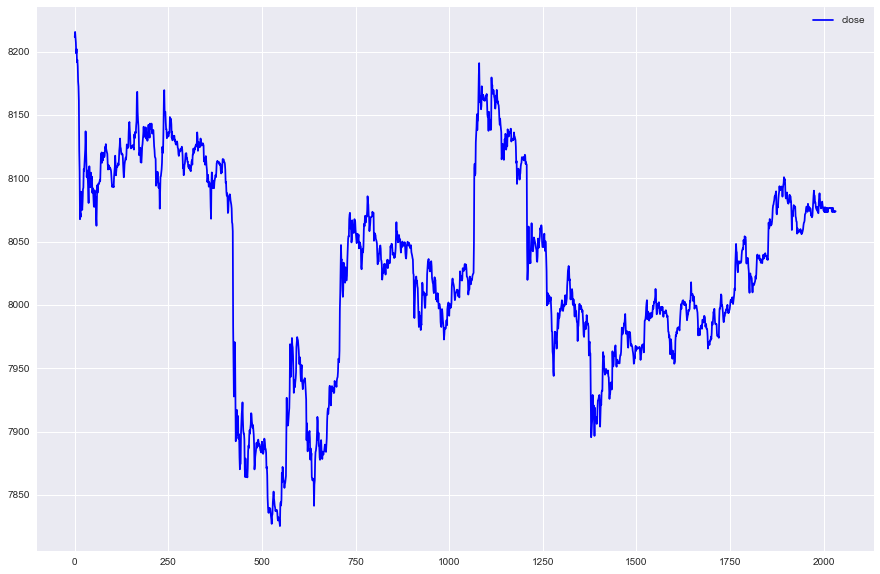

In [297]:
df[['close']].plot(color='blue')
plt.show()

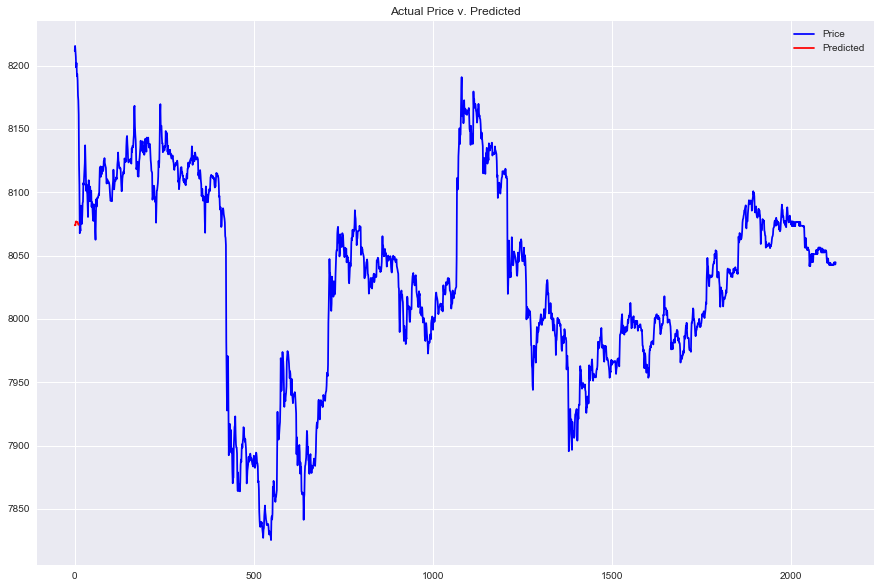

In [308]:
#Plot actual versus predicted:
orig = plt.plot(df.close.values, color='blue',label='Price')
pred = plt.plot(predicted_yhat.close.values, color='red', label='Predicted')
plt.legend(loc='best')
plt.title('Actual Price v. Predicted')
plt.show()

#predicted_yhat.DataFrame(predictions).to_csv('live_predict.csv');


## Summary

1. Code performs live prediction of BTC for every minute.
2. It gathers all the previous data and updates the LSTM model for every execution.
3. It also provides BUY and Sell signals of the price. 
4. Streaming chart also provides a live visual view about the price prediction.
5. Cryptocurrency API is used to get the live prices.
